In [176]:
import numpy as np
import pandas as pd
import sklearn
import re
import html
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import confusion_matrix
import warnings
# specify to ignore warning messages
warnings.filterwarnings("ignore") 

In [3]:
# Loading classified_tweets.txt
election = pd.read_csv('Canadian_elections_2019.csv')
election = election.replace(np.nan, '', regex=True)
tweets = pd.read_csv('Sentiment.csv')
election.head()

,sentiment,negative_reason,text
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,Positive,,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,Positive,,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


In [4]:
tweets.head()

,sentiment,text
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ..."
2,Positive,I'm listening The Beatles now. They're great
3,Positive,@ddlovato could i please get a shout out or an...
4,Positive,@salspizza just spotted ur message there Tony ...


# Step1. Data cleaning

In [5]:
#unicode to ascii
import ast
election['text'] = election['text'].apply(ast.literal_eval).str.decode("utf-8")

In [7]:
def getStopWordList(stopWordListFileName):
    # Read the stopwords file and build a list
    stop_words = ['today','day','will','going','twitter','gonna','tweet','tomorrow','now']
    f = open(stopWordListFileName, 'r')
    for line in f:
        word = line.strip()
        stop_words.append(word)
    f.close()
    return stop_words
stop_words = getStopWordList('stop_words.txt')

In [8]:
def processTweet(tweets):
    
    # Remove HTML tags
    pattern = re.compile(r'<[^>]+>')
    tweets = re.sub(pattern, '' , str(tweets))
    
    # Convert characters in the text to lower case
    tweets = tweets.lower()
    
    # Replace HTML charactercodes with ASCII
    tweets = html.unescape(tweets)
    
    # Remove all URLs
    tweets=re.sub('(http|https|ftp)://[a-zA-Z0-9\\./]+','',tweets)
    
    # Remove all stop words
    tweets_list = []
    for tw in tweets.split():
        if tw not in stop_words:
            tweets_list.append(tw)
            tweets_list.append(' ')
    tweets = ''.join(tweets_list)
    
    #clean all the non letter characters including numbers
    tweets = re.sub("[^a-zA-Z']",' ', tweets)
    
    return tweets

In [9]:
# Process data in tweets
for i in range(0,len(tweets)):
    tweets.iloc[i]['text'] = processTweet(tweets.iloc[i]['text'])
tweets.head()

,sentiment,text
0,Positive,rt diplomtc immnty realdonaldtrump poll n...
1,Negative,chiefy damn i'm jealous wanna watch fight ...
2,Positive,i'm listening beatles now they're great
3,Positive,ddlovato shout anything i'm huge fan wait cd
4,Positive,salspizza spotted ur message tony replied


In [10]:
# Process data in election
for i in range(len(election)):
    election.iloc[i]['text'] = processTweet(election.iloc[i]['text'])
election.head()

,sentiment,negative_reason,text
0,Negative,Women Reproductive right and Racism,rosiebarton suggestion agree canadian wome...
1,Positive,,allwomanspacewalk it's real space station ...
2,Negative,Economy,brantford it's cost billion years just...
3,Positive,,canada canadaelection canadavotes elxn...
4,Negative,Economy,canada taxpayers sick tired hard earned ...


# Step2. Exploratory Data Analysis

##2.1 Determine the political party of a given tweets

### 2.1.1 Top 3 Canadian Political Parties in 2019 Canadian Federal election:

**Liberal**

leader: Justin Trudeau

Slogan: Choose Forward

relevant words and hashtags: Trudeau, @JustinTrudeau, #ChooseForward, Liberal, @liberal_party, Justin, Liberals, #TrudeauMustGo

**Conservative**

leader: Andrew Scheer

Slogan: It's time for you to get ahead.

relevant words and hashtags: Scheer, @AndrewScheer, @CPC_HQ, Conservatives, CPC, Conservative, #CPC, Andrew, #Scheer, #ScheerLies

**New Democratic(NDP)**

leader: Jagmeet Singh

Slogan: In it for you.

relevant words and hashtags: NDP, @theJagmeetSingh, #UpRiSingh, #NDP, @NDP

### 2.1.2 Find out relevant political parties based on key words

In [11]:
# One-hot Encode election
# Cell with 'True' suggests the tweet is relevant to the corresponding political party
election["Liberal"] = election['text'].str.contains('justin|trudeau|justintrudeau|liberal|chooseforward')
election["Conservative"] = election['text'].str.contains('scheer|andrew|andrewscheer|conservative|cpc')
election["NewDemocratic"] = election['text'].str.contains('jagmeet|singh|thejagmeetsingh|newdemocratic|ndp|uprisingh')
election["None"] = election['text'].str.contains('justin|trudeau|justintrudeau|liberal|chooseforward|scheer|andrew|andrewscheer|conservative|cpc|jagmeet|singh|thejagmeetsingh|newdemocratic|ndp|uprisingh')

In [12]:
# Replacing values for 'True' with the corresponding party name
election.loc[election['Liberal']== True, 'Liberal'] = 'Liberal'
election.loc[election['Conservative']== True, 'Conservative'] = 'Conservative'
election.loc[election['NewDemocratic']== True, 'NewDemocratic'] = 'NewDemocratic'
election.loc[election['None']==False,'None']= 'None'
election.loc[election['Liberal']== False, 'Liberal'] = None
election.loc[election['Conservative']== False, 'Conservative'] = None
election.loc[election['NewDemocratic']== False, 'NewDemocratic'] = None
election.loc[election['None']==True,'None']=None

print(election['Liberal'].value_counts())
print(election['Conservative'].value_counts())
print(election['NewDemocratic'].value_counts())
print(election['None'].value_counts())

Liberal    642
Name: Liberal, dtype: int64
Conservative    711
Name: Conservative, dtype: int64
NewDemocratic    267
Name: NewDemocratic, dtype: int64
None    867
Name: None, dtype: int64


In [13]:
liberal = election["Liberal"]
conserv = election["Conservative"]
ND = election["NewDemocratic"]
none = election["None"]

# Concatenate columns for different political parties for countplot
election_tweet_plot = pd.concat([liberal, conserv, ND, none])
election_tweet_plot.unique()
party = pd.DataFrame(election_tweet_plot, columns = ['election_tweets'])
party.head()

,election_tweets
0,None
1,None
2,Liberal
3,None
4,Liberal


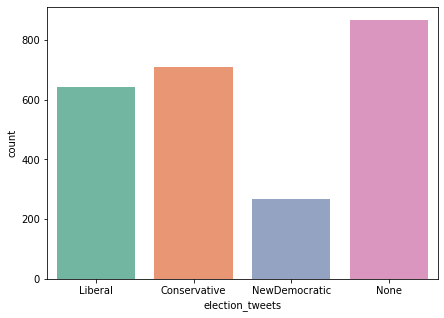

In [14]:
# Countplot for election tweets
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(7,5)
sns.countplot(data = party, x = 'election_tweets' , palette = 'Set2')

## 2.2 Find out relevant political parties based on key words

### 2.2.1 Visualization of Sentiment.csv

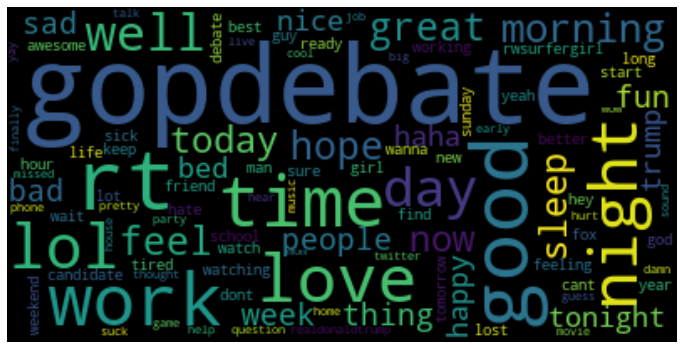

In [0]:
#world cloud of the generic tweets from Sentiment.csv
tweets_string="".join(tweets['text'])
wordcloud=WordCloud(max_words = 100, collocations=False).generate(tweets_string)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

### 2.2.1 Visualization of 2019 Canadian election tweets

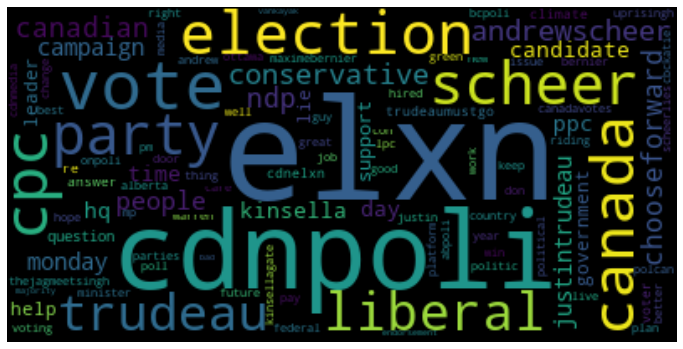

In [0]:
#world cloud of 2019 Canadian election tweets
election_string="".join(election['text'])
wordcloud=WordCloud(max_words = 100, collocations=False).generate(election_string)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

# Step3. Model Preparation

In [15]:
#drop the data in Sentiment.csv which sentiment is Neutral
tweets.drop(tweets[tweets.sentiment == 'Neutral'].index, inplace=True)
tweets['sentiment'].value_counts()

Negative    71428
Positive    59241
Name: sentiment, dtype: int64

## 3.1 Split into training data and test data

In [182]:
#split the dataset into features and targets.
X = tweets[['text']]
y_raw = tweets['sentiment']
#creating labelEncoder
le = preprocessing.LabelEncoder()
# Converting string labels into numbers.
y=le.fit_transform(y_raw)

In [183]:
#split into training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)

In [184]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(91468, 1)
(39201, 1)
(91468,)
(39201,)


## 3.2 Use WF to train a learning model

In [185]:
vectorizer1 = CountVectorizer(max_features = 1000,min_df=7, max_df=0.8)
vectorizer1.fit(X_train['text'])
X_train_wf = vectorizer1.transform(X_train['text'])
print(X_train_wf.shape)

(91468, 1000)


In [186]:
X_test_wf = vectorizer1.transform(X_test['text'])

## 3.3 Use TFIDF to train a learning model

In [42]:
vectorizer2 = TfidfVectorizer (max_features=1000, min_df=7, max_df=0.8)
vectorizer2.fit(X_train['text'])
X_train_tfidf = vectorizer2.transform(X_train['text'])
print(X_train_tfidf.shape)

(91468, 1000)


In [43]:
X_test_tfidf = vectorizer2.transform(X_test['text'])

# Step4. Model Implementation

Implement 6 different classification algorithms: Logistic Regression, k-NN, Naive Bayes, SVM, decision trees and Random Forest.

**Logistic Regression:**

pros: Convenient probability scores for observations; Simple to implement

cons: Poor performance on non-linear data

**K-NN:**

pros: Simple to understand and impelment; One Hyper Parameter; Constantly evolving model

cons: Slow for large datasets; Does not work very well on datasets with large number of features

**Naive Bayes:**

pros:Computationally fast and simple to implement; Good performance with high dimensional data

cons:Relies on independence assumption and will perform badly if this assumption is not met

**SVM:**

pros: Handle high dimensional data well; Performs well when classes are separable; Outliers have less impact

cons: Slow (For larger dataset, it requires a large amount of time to process); Poor performance with overlapped classes; Susceptible to overfitting/training issues depending on kernel

**Decision Trees:**

pros: Missing data can be handled; Easy to explain

cons:Prone to overfitting; Large trees can be difficult to interpret

**Ramdom Forest:**

pros: Random forest can decorrelate trees; Handling of huge amount of data; Missing data can be handled 

cons: Not as easy to visually interpret

## 4.1 WF

## 4.1.1 Train model on training data

In [21]:
#kfolder cross validation 
resultDF_wf = pd.DataFrame(columns=['model','hyperparams','train_acc','train_std','test_acc','test_std'])
df_i = 0

In [22]:
#set up cross validation
def run_kfold_wf(typ, model,hyperparams='default', verbose=0):
    global df_i
    
    # Initialize scaler
    scaler = StandardScaler(with_mean=False)
    
    # Update model hyperparameters if given
    if hyperparams is not 'default':
        model.set_params(**hyperparams)
    
    X = X_train_wf
    Y = y_train
    
    kf = KFold(n_splits=5) #n_splits previously n_folds
    
    # Initialize storage vectors
    test_outcomes = []
    train_outcomes=[]
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        # Scale data
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
       # Fit to training set
        model.fit(X_train, Y_train)
        
        # Make predictions on testing set and training set
        test_predictions = model.predict(X_test)
        train_predictions = model.predict(X_train)

        
        # Calculate the accuracy of test set and train set(coefficient of determination)
        acc_train = accuracy_score(Y_train, train_predictions)
        acc_test = accuracy_score(Y_test, test_predictions)

        test_outcomes.append(acc_test)
        train_outcomes.append(acc_train)
        
        # Print fold accuracy if verbose level 2
        if verbose == 2:
            print("Fold {0} test accuracy: {1}".format(fold, acc_test))   
    
    # Print average accuracy and standard deviation of accuracy if verbose level 1
    if verbose == 1:
        mean_outcome = np.mean(test_outcomes)
        mean_train_outcome=np.mean(train_outcomes)
        print("train accuracy: {0}".format(mean_train_outcome)) 
        print("test accuracy: {0}".format(mean_outcome)) 
    
    # Update dataframe
    resultDF_wf.loc[df_i, 'model'] = typ
    resultDF_wf.loc[df_i, 'hyperparams'] = str(hyperparams)
    resultDF_wf.loc[df_i, 'test_acc'] = np.mean(test_outcomes)
    resultDF_wf.loc[df_i, 'test_std'] = np.std(test_outcomes)
    resultDF_wf.loc[df_i, 'train_acc'] = np.mean(train_outcomes)
    resultDF_wf.loc[df_i, 'train_std'] = np.std(train_outcomes)
    df_i += 1                                         
        
    # Return average testing accuracy, and fitted model
    return np.mean(test_outcomes), model

In [23]:
models = {
    'lr': LogisticRegression(),
    'knn': KNeighborsClassifier(),
    'nb': MultinomialNB(),
    'svm': SVC(),
    'dt': DecisionTreeClassifier(),
    'rf': RandomForestClassifier()
}

In [24]:
for name, m in models.items():
    print ("Fitting " + name + " model")
    _, models[name] = run_kfold_wf(name, m, 'default',2)

Fitting lr model
Fold 1 test accuracy: 0.7191975511096534
Fold 2 test accuracy: 0.7172843555264021
Fold 3 test accuracy: 0.7179949710287526
Fold 4 test accuracy: 0.7078663969824524
Fold 5 test accuracy: 0.7106543486579566
Fitting knn model
Fold 1 test accuracy: 0.622772493713786
Fold 2 test accuracy: 0.6277468022302394
Fold 3 test accuracy: 0.624357712911337
Fold 4 test accuracy: 0.6304597386978625
Fold 5 test accuracy: 0.6260318154485323
Fitting nb model
Fold 1 test accuracy: 0.6951459494916366
Fold 2 test accuracy: 0.6996829561604898
Fold 3 test accuracy: 0.6929594402536351
Fold 4 test accuracy: 0.687093423713989
Fold 5 test accuracy: 0.6886787295686875
Fitting svm model
Fold 1 test accuracy: 0.7070077621077949
Fold 2 test accuracy: 0.712911337050399
Fold 3 test accuracy: 0.7140592544003499
Fold 4 test accuracy: 0.7053517739025857
Fold 5 test accuracy: 0.7057344339364784
Fitting dt model
Fold 1 test accuracy: 0.6666120039357166
Fold 2 test accuracy: 0.6630042636930141
Fold 3 test acc

In [25]:
resultDF_wf = resultDF_wf.sort_values('test_acc',ascending=False).reset_index(drop=True)
resultDF_wf.groupby('model').first().sort_values('test_acc',ascending=False)

,hyperparams,train_acc,train_std,test_acc,test_std
model,,,,,
lr,default,0.725142,0.001416,0.714600,0.004490
svm,default,0.823925,0.000803,0.709013,0.003710
nb,default,0.700330,0.000845,0.692712,0.004526
rf,default,0.910947,0.000485,0.686415,0.002786
dt,default,0.922519,0.000342,0.663642,0.002176
knn,default,0.728151,0.001175,0.626274,0.002671


### 4.1.2 Hyperparameter Tuning

In [26]:
best_wf = pd.DataFrame(columns=['accuracy','f1_score','model'])

In [28]:
#Logistic regression
for C in [0.001,0.01,0.05,0.1,0.5,1,10,100]:
    for solver in ['newton-cg','lbfgs','liblinear','sag']: 
        model = LogisticRegression(C=C, solver=solver)
        best_model = model
        name = 'lr' 
        verbose = 1   

        # Get current best accuracy for model from the results dataframe
        best_acc = resultDF_wf[resultDF_wf['model'] == name]['test_acc'].max()
        params = {'C':C,'solver':solver}
            
        # Cross validate model with selected hyperparams using the function we generated earlier
        acc,model = run_kfold_wf(name, model, params, 0)
                    
        # Update best model if it satisfies our optimizing metric
        if acc > best_acc:
            if verbose == 1:
                print ('    New best ' +  name + ' model: ' + str(acc))
                best_model = model
#use best model to predict the 30% X_test data
best_model.fit(X_train_wf, y_train)
best_lr_pred = best_model.predict(X_test_wf)
acc_lr_wf = accuracy_score(y_test,best_lr_pred)
f1_lr_wf = f1_score(y_test,best_lr_pred)
print('30% testing data accuracy:',acc_lr_wf)
print('30% testing f1_score:',f1_lr_wf)
#save the outcome of 30% testing data 
best_wf.loc[0, 'accuracy'] = acc_lr_wf
best_wf.loc[0,'f1_score'] = f1_lr_wf
best_wf.loc[0,'model'] = 'lr'

    New best lr model: 0.7152664195408018
30% testing data accuracy: 0.7128644677431698
30% testing f1_score: 0.6957508919883232


In [29]:
# K-NN
# Beacause K-NN runs slow for large datasets, so I can't choose a variety of k values
for n_neighbors in [2,10,50,100]: 
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    best_model = model
    name = 'knn' 
    verbose = 1   

    # Get current best accuracy for model from the results dataframe
    best_acc = resultDF_wf[resultDF_wf['model'] == name]['test_acc'].max()
            
    params = {'n_neighbors':n_neighbors}
            
    # Cross validate model with selected hyperparams using the function we generated earlier
    acc,model = run_kfold_wf(name, model, params, 0)
                    
    # Update best model if it satisfies our optimizing metric
    if acc > best_acc:
        if verbose == 1:
            print ('    New best ' +  name + ' model: ' + str(acc))
            best_model = model
#use best model to predict the 30% X_test data
best_model.fit(X_train_wf, y_train)
best_knn_pred = best_model.predict(X_test_wf)
acc_knn_wf = accuracy_score(y_test,best_knn_pred)
f1_knn_wf = f1_score(y_test,best_knn_pred)
print('30% testing data accuracy:',acc_knn_wf)
print('30% testing f1_score:',f1_knn_wf)
#save the outcome of 30% testing data 
best_wf.loc[1,'accuracy'] = acc_knn_wf
best_wf.loc[1,'f1_score'] = f1_knn_wf
best_wf.loc[1,'model'] = 'knn'

    New best knn model: 0.6863055351368408
30% testing data accuracy: 0.666819723986633
30% testing f1_score: 0.588098016336056


In [30]:
# Naive Bayes
for alpha in [0.5,1,1.5,2,6,10]:
    for fit_prior in [True, False]:
        verbose =1 
        model = MultinomialNB(alpha=alpha,fit_prior=fit_prior)
        best_model = model
        name = 'nb'    

        # Get current best accuracy for model from the results dataframe
        best_acc = resultDF_wf[resultDF_wf['model'] == name]['test_acc'].max()
        params = {'alpha':alpha,'fit_prior':fit_prior}
        
        # Cross validate model with selected hyperparams using the function we generated earlier
        acc,model = run_kfold_wf(name, model, params, 0)
                
        # Update best model if it satisfies our optimizing metric
        if acc > best_acc:
            if verbose == 1:
                print ('    New best ' +  name + ' model: ' + str(acc))
                best_model = model

#use best model to predict the 30% X_test data
best_model.fit(X_train_wf, y_train)
best_nb_pred = best_model.predict(X_test_wf)
acc_nb_wf = accuracy_score(y_test,best_nb_pred)
f1_nb_wf = f1_score(y_test,best_nb_pred)
print('30% testing data accuracy:',acc_nb_wf)
print('30% testing f1_score:',f1_nb_wf)
#save the outcome of 30% testing data 
best_wf.loc[2, 'accuracy'] = acc_nb_wf
best_wf.loc[2,'f1_score'] = f1_nb_wf
best_wf.loc[2,'model'] = 'nb'

    New best nb model: 0.692733965527703
    New best nb model: 0.6927667643615442
30% testing data accuracy: 0.6943445320272442
30% testing f1_score: 0.6754428733950918


In [31]:
#SVM
#Since SVM hyperparamers are C and gamma, but since implement a SVM model will use nearly 2 hours, I only select a few values in C
for C in [0.1,0.5,1,10]: 
    model = SVC(C = C)
    best_model = model
    name = 'svm' 
    verbose = 1   

    # Get current best accuracy for model from the results dataframe
    best_acc = resultDF_wf[resultDF_wf['model'] == name]['test_acc'].max()
            
    params = {'C':C}
            
    # Cross validate model with selected hyperparams using the function we generated earlier
    acc,model = run_kfold_wf(name, model, params, 0)
                    
    # Update best model if it satisfies our optimizing metric
    if acc > best_acc:
        if verbose == 1:
            print ('    New best ' +  name + ' model: ' + str(acc))
            best_model = model
#use best model to predict the 30% X_test data
best_model.fit(X_train_wf, y_train)
best_svm_pred = best_model.predict(X_test_wf)
acc_svm_wf = accuracy_score(y_test,best_svm_pred)
f1_svm_wf = f1_score(y_test,best_svm_pred)
print('30% testing data accuracy:',acc_svm_wf)
print('30% testing f1_score:',f1_svm_wf)
#save the outcome of 30% testing data 
best_wf.loc[3, 'accuracy'] = acc_svm_wf
best_wf.loc[3, 'f1_score'] = f1_svm_wf
best_wf.loc[3,'model'] = 'svm'

30% testing data accuracy: 0.6345501390270656
30% testing f1_score: 0.42410355362598495


In [32]:
#decision tree
for max_features in ['auto','sqrt']: 
    for max_depth in [2,3,4,5,6]:
        model = DecisionTreeClassifier(max_features=max_features, max_depth=max_depth)
        best_model = model
        name = 'dt'
        verbose = 1    

        # Get current best accuracy for model from the results dataframe
        best_acc = resultDF_wf[resultDF_wf['model'] == name]['test_acc'].max()
            
        params = {'max_features':max_features,'max_depth': max_depth}
            
        # Cross validate model with selected hyperparams using the function we generated earlier
        acc,model = run_kfold_wf(name, model, params, 0)
                    
        # Update best model if it satisfies our optimizing metric
        if acc > best_acc:
            if verbose == 1:
                print ('    New best ' +  name + ' model: ' + str(acc))
                best_model = model
#use best model to predict the 30% X_test data
best_model.fit(X_train_wf, y_train)
best_dt_pred = best_model.predict(X_test_wf)
acc_dt_wf = accuracy_score(y_test,best_dt_pred)
f1_dt_wf = f1_score(y_test,best_dt_pred)
print('30% testing data accuracy:',acc_dt_wf)
print('30% testing f1_score:',f1_dt_wf)
#save the outcome of 30% testing data 
best_wf.loc[4, 'accuracy'] = acc_dt_wf
best_wf.loc[4,'f1_score'] = f1_dt_wf
best_wf.loc[4,'model'] = 'dt'

30% testing data accuracy: 0.5634805234560343
30% testing f1_score: 0.10828556539864513


In [34]:
#random forrest
for n_estimators in [50,150,200]: 
    for max_depth in [None,1,5]:
        model = RandomForestClassifier(max_features=max_features, max_depth=max_depth)
        best_model = model
        name = 'rf'
        verbose = 1    

        # Get current best accuracy for model from the results dataframe
        best_acc = resultDF_wf[resultDF_wf['model'] == name]['test_acc'].max()
            
        params = {'max_features':max_features,'max_depth': max_depth}
            
        # Cross validate model with selected hyperparams using the function we generated earlier
        acc,model = run_kfold_wf(name, model, params, 0)
                    
        # Update best model if it satisfies our optimizing metric
        if acc > best_acc:
            if verbose == 1:
                print ('    New best ' +  name + ' model: ' + str(acc))
                best_model = model
#use best model to predict the 30% X_test data
best_model.fit(X_train_wf, y_train)
best_rf_pred = best_model.predict(X_test_wf)
acc_rf_wf = accuracy_score(y_test,best_rf_pred)
f1_rf_wf = f1_score(y_test,best_rf_pred)
print('30% testing data accuracy:',acc_rf_wf)
print('30% testing f1_score:',f1_rf_wf)
#save the outcome of 30% testing data 
best_wf.loc[5, 'accuracy'] = acc_rf_wf
best_wf.loc[5,'f1_score'] = f1_rf_wf
best_wf.loc[5,'model'] = 'rf'

30% testing data accuracy: 0.567536542435142
30% testing f1_score: 0.11217596229379419


In [35]:
resultDF_wf = resultDF_wf.sort_values('test_acc',ascending=False).reset_index(drop=True)
resultDF_wf_1 = resultDF_wf.groupby('model').first().sort_values('test_acc',ascending=False)

In [36]:
resultDF_wf_2= pd.merge(resultDF_wf_1, best_wf, how='left', on='model')
resultDF_wf_2

,model,hyperparams,train_acc,train_std,test_acc,test_std,accuracy,f1_score
0,lr,"{'C': 0.001, 'solver': 'newton-cg'}",0.724592,0.001311,0.715266,0.004648,0.712864,0.695751
1,svm,default,0.823925,0.000803,0.709013,0.003710,0.63455,0.424104
2,nb,"{'alpha': 10, 'fit_prior': True}",0.700341,0.000814,0.692767,0.004556,0.694345,0.675443
3,rf,default,0.910947,0.000485,0.686415,0.002786,0.567537,0.112176
4,knn,{'n_neighbors': 100},0.698321,0.001139,0.686306,0.002251,0.66682,0.588098
5,dt,default,0.922519,0.000342,0.663642,0.002176,0.563481,0.108286


Based on the accuracy_score on the validation folder of 5-folder cross validation and the accuracy_score and f1_score of the testing data, the best model of WF features is logistic regression.

# 4.2 TFIDF

## 4.2.1 Train model on training data

In [0]:
resultDF_tfidf = pd.DataFrame(columns=['model','hyperparams','train_acc','train_std','test_acc','test_std'])
df_idx = 0

In [44]:
#set up cross validation
def run_kfold(typ, model,hyperparams='default', verbose=0):
    global df_idx
    
    # Initialize scaler
    scaler = StandardScaler(with_mean=False)
    
    # Update model hyperparameters if given
    if hyperparams is not 'default':
        model.set_params(**hyperparams)
    
    X = X_train_tfidf
    Y = y_train
    
    kf = KFold(n_splits=5) #n_splits previously n_folds
    
    # Initialize storage vectors
    test_outcomes = []
    train_outcomes=[]
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        # Scale data
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
       # Fit to training set
        model.fit(X_train, Y_train)
        
        # Make predictions on testing set and training set
        test_predictions = model.predict(X_test)
        train_predictions = model.predict(X_train)

        
        # Calculate the accuracy of test set and train set(coefficient of determination)
        acc_train = accuracy_score(Y_train, train_predictions)
        acc_test = accuracy_score(Y_test, test_predictions)

        test_outcomes.append(acc_test)
        train_outcomes.append(acc_train)
        
        # Print fold accuracy if verbose level 2
        if verbose == 2:
            print("Fold {0} test accuracy: {1}".format(fold, acc_test))   
    
    # Print average accuracy and standard deviation of accuracy if verbose level 1
    if verbose == 1:
        mean_outcome = np.mean(test_outcomes)
        mean_train_outcome=np.mean(train_outcomes)
        print("train accuracy: {0}".format(mean_train_outcome)) 
        print("test accuracy: {0}".format(mean_outcome)) 
    
    # Update dataframe
    resultDF_tfidf.loc[df_idx, 'model'] = typ
    resultDF_tfidf.loc[df_idx, 'hyperparams'] = str(hyperparams)
    resultDF_tfidf.loc[df_idx, 'test_acc'] = np.mean(test_outcomes)
    resultDF_tfidf.loc[df_idx, 'test_std'] = np.std(test_outcomes)
    resultDF_tfidf.loc[df_idx, 'train_acc'] = np.mean(train_outcomes)
    resultDF_tfidf.loc[df_idx, 'train_std'] = np.std(train_outcomes)
    df_idx += 1                                         
        
    # Return average testing accuracy, and fitted model
    return np.mean(test_outcomes), model

In [0]:
models = {
    'lr': LogisticRegression(),
    'knn': KNeighborsClassifier(),
    'nb': MultinomialNB(),
    'svm': SVC(),
    'dt': DecisionTreeClassifier(),
    'rf': RandomForestClassifier()
}

In [0]:
for name, m in models.items():
    print ("Fitting " + name + " model")
    _, models[name] = run_kfold(name, m, 'default',2)

Fitting lr model
Fold 1 test accuracy: 0.7185415983382529
Fold 2 test accuracy: 0.7178309828359025
Fold 3 test accuracy: 0.7177763201049524
Fold 4 test accuracy: 0.7096703657136609
Fold 5 test accuracy: 0.7085770513311103
Fitting knn model
Fold 1 test accuracy: 0.6231004700994862
Fold 2 test accuracy: 0.6268721985350388
Fold 3 test accuracy: 0.6222805291352356
Fold 4 test accuracy: 0.6306784015743727
Fold 5 test accuracy: 0.6246651724703438
Fitting nb model
Fold 1 test accuracy: 0.6935607302940855
Fold 2 test accuracy: 0.6992456543128894
Fold 3 test accuracy: 0.6940526948726359
Fold 4 test accuracy: 0.6881320723774121
Fold 5 test accuracy: 0.6888973924451977
Fitting svm model
Fold 1 test accuracy: 0.708592981305346
Fold 2 test accuracy: 0.7081010167267957
Fold 3 test accuracy: 0.7108341532742976
Fold 4 test accuracy: 0.7034931394522494
Fold 5 test accuracy: 0.7039851309243973
Fitting dt model
Fold 1 test accuracy: 0.6696731168689187
Fold 2 test accuracy: 0.6679785722094675
Fold 3 test 

In [64]:
resultDF_tfidf = resultDF_tfidf.sort_values('test_acc',ascending=False).reset_index(drop=True)
resultDF_tfidf.groupby('model').first().sort_values('test_acc',ascending=False)

,model,hyperparams,train_acc,train_std,test_acc,test_std
0,lr,default,0.725953,0.00107929,0.714479,0.00439474
1,svm,default,0.824824,0.000771176,0.707001,0.0028227
2,rf,default,0.921962,0.000339922,0.703645,0.00405806
3,nb,default,0.700507,0.00113394,0.692778,0.00401776
4,dt,default,0.921992,0.000342742,0.667917,0.00178131
5,knn,default,0.732546,0.00130027,0.625519,0.00301717


### 4.2.2 Hyperparameter Tuning



In [45]:
best_tf = pd.DataFrame(columns=['model','accuracy','f1_score'])

In [46]:
# Logistic regression
for C in [0.001,0.01,0.05,0.1,0.5,1,10,100]:
    for solver in ['newton-cg','lbfgs','liblinear','sag']: 
        model = LogisticRegression(C=C, solver=solver)
        best_model = model
        name = 'lr' 
        verbose = 1   

        # Get current best accuracy for model from the results dataframe
        best_acc = resultDF_tfidf[resultDF_tfidf['model'] == name]['test_acc'].max()
        params = {'C':C,'solver':solver}
            
        # Cross validate model with selected hyperparams using the function we generated earlier
        acc,model = run_kfold(name, model, params, 0)
                    
        # Update best model if it satisfies our optimizing metric
        if acc > best_acc:
            if verbose == 1:
                print ('    New best ' +  name + ' model: ' + str(acc))
                best_model = model
#use best model to predict the 30% X_test data
best_model.fit(X_train_tfidf, y_train)
best_lr_pred = best_model.predict(X_test_tfidf)
acc_lr_tf = accuracy_score(y_test,best_lr_pred)
f1_lr_tf = f1_score(y_test,best_lr_pred)
print('30% testing data accuracy:',acc_lr_tf)
print('30% testing f1_score:',f1_lr_tf)
#save the outcome of 30% testing data 
best_tf.loc[0, 'accuracy'] = acc_lr_tf
best_tf.loc[0,'f1_score'] = f1_lr_tf
best_tf.loc[0,'model'] = 'lr'

30% testing data accuracy: 0.7136552638963292
30% testing f1_score: 0.6954280287613621


In [47]:
# K-NN
# Beacause K-NN runs slow for large datasets, so I can't choose a variety of k values
for n_neighbors in [2,10,25,50,100]: 
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    best_model = model
    name = 'knn' 
    verbose = 1   

    # Get current best accuracy for model from the results dataframe
    best_acc = resultDF_tfidf[resultDF_tfidf['model'] == name]['test_acc'].max()
            
    params = {'n_neighbors':n_neighbors}
            
    # Cross validate model with selected hyperparams using the function we generated earlier
    acc,model = run_kfold(name, model, params, 0)
                    
    # Update best model if it satisfies our optimizing metric
    if acc > best_acc:
        if verbose == 1:
            print ('    New best ' +  name + ' model: ' + str(acc))
            best_model = model
#use best model to predict the 30% X_test data
best_model.fit(X_train_tfidf, y_train)
best_knn_pred = best_model.predict(X_test_tfidf)
acc_knn_tf = accuracy_score(y_test,best_knn_pred)
f1_knn_tf = f1_score(y_test,best_knn_pred)
print('30% testing data accuracy:',acc_knn_tf)
print('30% testing f1_score:',f1_knn_tf)
#save the outcome of 30% testing data 
best_tf.loc[1,'accuracy'] = acc_knn_tf
best_tf.loc[1,'f1_score'] = f1_knn_tf
best_tf.loc[1,'model'] = 'knn'

30% testing data accuracy: 0.6471518583709599
30% testing f1_score: 0.49374130737134914


In [49]:
# Naive Bayes
for alpha in [0.5,1,1.5,2,6,10]:
    for fit_prior in [True, False]:
        verbose =1 
        model = MultinomialNB(alpha=alpha,fit_prior=fit_prior)
        best_model = model
        name = 'nb'    

        # Get current best accuracy for model from the results dataframe
        best_acc = resultDF_tfidf[resultDF_tfidf['model'] == name]['test_acc'].max()
        params = {'alpha':alpha,'fit_prior':fit_prior}
        
        # Cross validate model with selected hyperparams using the function we generated earlier
        acc,model = run_kfold(name, model, params, 0)
                
        # Update best model if it satisfies our optimizing metric
        if acc > best_acc:
            if verbose == 1:
                print ('    New best ' +  name + ' model: ' + str(acc))
                best_model = model
#use best model to predict the 30% X_test data
best_model.fit(X_train_tfidf, y_train)
best_nb_pred = best_model.predict(X_test_tfidf)
acc_nb_tf = accuracy_score(y_test,best_nb_pred)
f1_nb_tf = f1_score(y_test,best_nb_pred)
print('30% testing data accuracy:',acc_nb_tf)
print('30% testing f1_score:',f1_nb_tf)
#save the outcome of 30% testing data 
best_tf.loc[2, 'accuracy'] = acc_nb_tf
best_tf.loc[2,'f1_score'] = f1_nb_tf
best_tf.loc[2,'model'] = 'nb'

30% testing data accuracy: 0.7045993724649882
30% testing f1_score: 0.650193330111165


In [50]:
#SVM
#Since SVM hyperparamers are C and gamma, but since implement a SVM model will use nearly 2 hours, I only select a few values in C
for C in [0.1,0.5,1,10]: 
    model = SVC(C = C)
    best_model = model
    name = 'svm' 
    verbose = 1   

    # Get current best accuracy for model from the results dataframe
    best_acc = resultDF_tfidf[resultDF_tfidf['model'] == name]['test_acc'].max()
            
    params = {'C':C}
            
    # Cross validate model with selected hyperparams using the function we generated earlier
    acc,model = run_kfold(name, model, params, 0)
                    
    # Update best model if it satisfies our optimizing metric
    if acc > best_acc:
        if verbose == 1:
            print ('    New best ' +  name + ' model: ' + str(acc))
            best_model = model
#use best model to predict the 30% X_test data
best_model.fit(X_train_tfidf, y_train)
best_svm_pred = best_model.predict(X_test_tfidf)
acc_svm_tf = accuracy_score(y_test,best_svm_pred)
f1_svm_tf = f1_score(y_test,best_svm_pred)
print('30% testing data accuracy:',acc_svm_tf)
print('30% testing f1_score:',f1_svm_tf)
#save the outcome of 30% testing data 
best_tf.loc[3, 'accuracy'] = acc_svm_tf
best_tf.loc[3, 'f1_score'] = f1_svm_tf
best_tf.loc[3, 'model'] = 'svm'

30% testing data accuracy: 0.5573072115507257
30% testing f1_score: 0.04606420404573439


In [51]:
#decision tree
for max_features in ['auto','sqrt']: 
    for max_depth in [None,2,3,4,5,6]:
        model = DecisionTreeClassifier(max_features=max_features, max_depth=max_depth)
        best_model = model
        name = 'dt'
        verbose = 1    

        # Get current best accuracy for model from the results dataframe
        best_acc = resultDF_tfidf[resultDF_tfidf['model'] == name]['test_acc'].max()
            
        params = {'max_features':max_features,'max_depth': max_depth}
            
        # Cross validate model with selected hyperparams using the function we generated earlier
        acc,model = run_kfold(name, model, params, 0)
                    
        # Update best model if it satisfies our optimizing metric
        if acc > best_acc:
            if verbose == 1:
                print ('    New best ' +  name + ' model: ' + str(acc))
                best_model = model
#use best model to predict the 30% X_test data
best_model.fit(X_train_tfidf, y_train)
best_dt_pred = best_model.predict(X_test_tfidf)
acc_dt_tf = accuracy_score(y_test,best_dt_pred)
f1_dt_tf = f1_score(y_test,best_dt_pred)
print('30% testing data accuracy:',acc_dt_tf)
print('30% testing f1_score:',f1_dt_tf)
#save the outcome of 30% testing data 
best_tf.loc[4, 'accuracy'] = acc_dt_tf
best_tf.loc[4,'f1_score'] = f1_dt_tf
best_tf.loc[4, 'model'] = 'dt'

30% testing data accuracy: 0.664523864187138
30% testing f1_score: 0.6402013624798227


In [52]:
#random forrest
for n_estimators in [50,150,200]: 
    for max_depth in [None,1,5]:
        model = RandomForestClassifier(max_features=max_features, max_depth=max_depth)
        best_model = model
        name = 'rf'
        verbose = 1    

        # Get current best accuracy for model from the results dataframe
        best_acc = resultDF_tfidf[resultDF_tfidf['model'] == name]['test_acc'].max()
            
        params = {'max_features':max_features,'max_depth': max_depth}
            
        # Cross validate model with selected hyperparams using the function we generated earlier
        acc,model = run_kfold(name, model, params, 0)
                    
        # Update best model if it satisfies our optimizing metric
        if acc > best_acc:
            if verbose == 1:
                print ('    New best ' +  name + ' model: ' + str(acc))
                best_model = model
#use best model to predict the 30% X_test data
best_model.fit(X_train_tfidf, y_train)
best_rf_pred = best_model.predict(X_test_tfidf)
acc_rf_tf = accuracy_score(y_test,best_rf_pred)
f1_rf_tf = f1_score(y_test,best_rf_pred)
print('30% testing data accuracy:',acc_rf_tf)
print('30% testing f1_score:',f1_rf_tf)
#save the outcome of 30% testing data 
best_tf.loc[5, 'accuracy'] = acc_rf_tf
best_tf.loc[5,'f1_score'] = f1_rf_tf
best_tf.loc[5, 'model'] = 'rf'

30% testing data accuracy: 0.6942424938139333
30% testing f1_score: 0.6669815514558791


In [54]:
resultDF_tfidf = resultDF_tfidf.sort_values('test_acc',ascending=False).reset_index(drop=True)
resultDF_tfidf_1 = resultDF_tfidf.groupby('model').first().sort_values('test_acc',ascending=False)

In [55]:
resultDF_tfidf_2= pd.merge(resultDF_tfidf_1, best_tf, how='left', on='model')
resultDF_tfidf_2

,model,hyperparams,train_acc,train_std,test_acc,test_std,accuracy,f1_score
0,lr,"{'C': 10, 'solver': 'sag'}",0.726063,0.001150,0.714610,0.004323,0.713655,0.695428
1,svm,default,0.824824,0.000771,0.707001,0.002823,0.557307,0.0460642
2,dt,"{'max_features': 'sqrt', 'max_depth': None}",0.921959,0.000340,0.705514,0.003602,0.664524,0.640201
3,rf,default,0.921962,0.000340,0.703645,0.004058,0.694242,0.666982
4,nb,"{'alpha': 6, 'fit_prior': True}",0.700474,0.001158,0.692800,0.003995,0.704599,0.650193
5,knn,{'n_neighbors': 100},0.675020,0.002468,0.661018,0.003156,0.647152,0.493741


# 4.3 Evaluate model on the 2019 Canadian elections data

In [58]:
#label encoding for election data
election['score'] = election['sentiment'].apply(lambda x: 0 if 'Negative' in x else 1)
election.head()

,sentiment,negative_reason,text,Liberal,Conservative,NewDemocratic,None,score
0,Negative,Women Reproductive right and Racism,rosiebarton suggestion agree canadian wome...,None,Conservative,None,None,0
1,Positive,,allwomanspacewalk it's real space station ...,None,None,None,None,1
2,Negative,Economy,brantford it's cost billion years just...,Liberal,None,None,None,0
3,Positive,,canada canadaelection canadavotes elxn...,None,None,None,None,1
4,Negative,Economy,canada taxpayers sick tired hard earned ...,Liberal,None,None,None,0


In [59]:
#split the dataset into features and targets.
X_el = election[['text']]
y_el=election['score']

In [199]:
#choose the best model of logistic regression with wf
#select the whole sentiment set as the training set and the election dataset as test set
vectorizer3 = CountVectorizer(max_features = 1000)
vectorizer3.fit(X['text'])
X_train_sen= vectorizer3.transform(X['text'])
y_train_sen=y
X_test_el = vectorizer3.transform(X_el['text'])
y_test_el = y_el

In [65]:
#predict the sentiment of election data and show the accuracy and classification_report
model = LogisticRegression(C= 0.001, solver='newton-cg')
model.fit(X_train_sen,y_train_sen)
y_el_pred=model.predict(X_test_el)
print('Accuracy: %.2f%%' % (accuracy_score(y_test_el, y_el_pred)*100))

Accuracy: 51.66%


In [66]:
print(classification_report(y_test_el, y_el_pred))

              precision    recall  f1-score   support

           0       0.49      0.88      0.63      1006
           1       0.64      0.19      0.29      1127

   micro avg       0.52      0.52      0.52      2133
   macro avg       0.57      0.54      0.46      2133
weighted avg       0.57      0.52      0.45      2133



In [67]:
print(confusion_matrix(y_test_el, y_el_pred))

[[887 119]
 [912 215]]


In [70]:
pd.crosstab(y_test_el, y_el_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,887,119,1006
1,912,215,1127
All,1799,334,2133


## 4.4 visualize the sentiments for different parties

In [71]:
election['pred'] = y_el_pred
election.head()

,sentiment,negative_reason,text,Liberal,Conservative,NewDemocratic,None,score,pred
0,Negative,Women Reproductive right and Racism,rosiebarton suggestion agree canadian wome...,None,Conservative,None,None,0,0
1,Positive,,allwomanspacewalk it's real space station ...,None,None,None,None,1,0
2,Negative,Economy,brantford it's cost billion years just...,Liberal,None,None,None,0,0
3,Positive,,canada canadaelection canadavotes elxn...,None,None,None,None,1,0
4,Negative,Economy,canada taxpayers sick tired hard earned ...,Liberal,None,None,None,0,0


In [78]:
liberal = election.loc[election['Liberal']=='Liberal']
conservative = election.loc[election['Conservative']=='Conservative']
NDP = election.loc[election['NewDemocratic']=='NewDemocratic']

### 4.4.1 Liberal

In [79]:
#true sentiments
liberal['score'].value_counts()

0    327
1    315
Name: score, dtype: int64

In [81]:
#sentiments predictions
liberal['pred'].value_counts()

0    534
1    108
Name: pred, dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

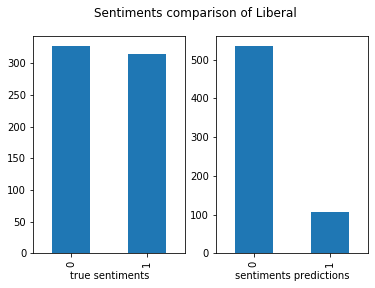

In [207]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sentiments comparison of Liberal')
p1 = plt.subplot(121) 
liberal['score'].value_counts().plot.bar() 
p1.set_xlabel('true sentiments')
plt.sca(p1)

p2 = plt.subplot(122)  
liberal['pred'].value_counts().plot.bar() 
p2.set_xlabel('sentiments predictions')
plt.sca(p2)
plt.show

### 4.4.2 Conservative

In [82]:
#true sentiments
conservative['score'].value_counts()

0    464
1    247
Name: score, dtype: int64

In [83]:
#sentiments prediction
conservative['pred'].value_counts()

0    623
1     88
Name: pred, dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

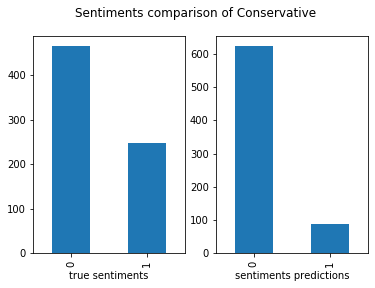

In [208]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sentiments comparison of Conservative')
p1 = plt.subplot(121) 
conservative['score'].value_counts().plot.bar() 
p1.set_xlabel('true sentiments')
plt.sca(p1)

p2 = plt.subplot(122)  
conservative['pred'].value_counts().plot.bar() 
p2.set_xlabel('sentiments predictions')
plt.sca(p2)
plt.show

### 4.4.3 NDP

In [84]:
#true sentiments
NDP['score'].value_counts()

1    165
0    102
Name: score, dtype: int64

In [85]:
#sentiments prediction
NDP['pred'].value_counts()

0    228
1     39
Name: pred, dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

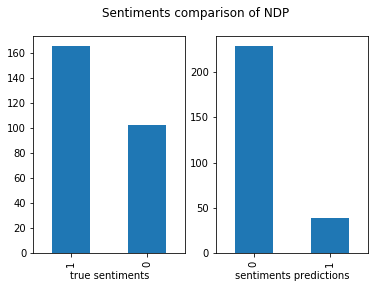

In [209]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sentiments comparison of NDP')
p1 = plt.subplot(121) 
NDP['score'].value_counts().plot.bar() 
p1.set_xlabel('true sentiments')
plt.sca(p1)

p2 = plt.subplot(122)  
NDP['pred'].value_counts().plot.bar() 
p2.set_xlabel('sentiments predictions')
plt.sca(p2)
plt.show

### 4.4.4 Analysis

# 4.4 Negative Reason Predict

In [93]:
#find all negative election tweets
el_negative=election['sentiment'].str.contains("Negative")
df_nega_el = election[el_negative]
df_nega_el.head()

,sentiment,negative_reason,text,Liberal,Conservative,NewDemocratic,None,score,pred
0,Negative,Women Reproductive right and Racism,rosiebarton suggestion agree canadian wome...,None,Conservative,None,None,0,0
2,Negative,Economy,brantford it's cost billion years just...,Liberal,None,None,None,0,0
4,Negative,Economy,canada taxpayers sick tired hard earned ...,Liberal,None,None,None,0,0
5,Negative,Others,canadavotes elxn cdnpoli facts b...,None,Conservative,None,None,0,0
8,Negative,Others,chooseforward cdnpoli elxn canada americ...,Liberal,None,None,None,0,0


In [108]:
df_nega_el['negative_reason'] = df_nega_el['negative_reason'].astype('category')
df_nega_el['negative_reason'].cat.categories

Index(['Climate Problem', 'Economy', 'Healthcare', 'Healthcare and Marijuana',
       'Others', 'Privilege', 'Scandal', 'Separation', 'Tell lies',
       'Women Reproductive right and Racism'],
      dtype='object')

**combine similar reasons into fewer categories**:

combine 'Healthcare' and 'Healthcare and Marijuana' to 'Healthcare and Marijuana', since they both care about Healthcare.

combine 'Scandal' and 'Tell lies' to 'Crisis of Confidence', since both of them will cause people no longer believe the candidate.

In [109]:
t1=df_nega_el['negative_reason'].str.replace('Healthcare','Healthcare and Marijuana')
t2=t1.str.replace('Scandal','Crisis of Confidence').str.replace('Tell lies','Crisis of Confidence')

In [153]:
X_ne=df_nega_el['text'].values
y_ne=t2.values

In [154]:
X_train_ne, X_test_ne, y_train_ne, y_test_ne = train_test_split(X_ne,y_ne,test_size=0.3, random_state=101)

In [155]:
#use ef to verctorize
vectorizer4 = CountVectorizer ()
vectorizer4.fit(X_train_ne)
X_train_ne = vectorizer4.transform(X_train_ne)
print(X_train_ne.shape)

(704, 4035)


In [156]:
X_test_ne = vectorizer4.transform(X_test_ne)

In [158]:
#choose logistic regression
model1 = LogisticRegression()
model1.fit(X_train_ne,y_train_ne)
ne_pred = model1.predict(X_test_ne)

In [160]:
resultsDF_lr = pd.DataFrame({
        'true':y_test_ne,
        'predicted':ne_pred
    })
resultsDF_lr.head()

,true,predicted
0,Others,Others
1,Crisis of Confidence,Others
2,Women Reproductive right and Racism,Others
3,Crisis of Confidence,Crisis of Confidence
4,Others,Others


In [163]:
print('lr Accuracy: %.2f%%' % (accuracy_score(y_test_ne,ne_pred)*100))

lr Accuracy: 57.95%


<function matplotlib.pyplot.show(*args, **kw)>

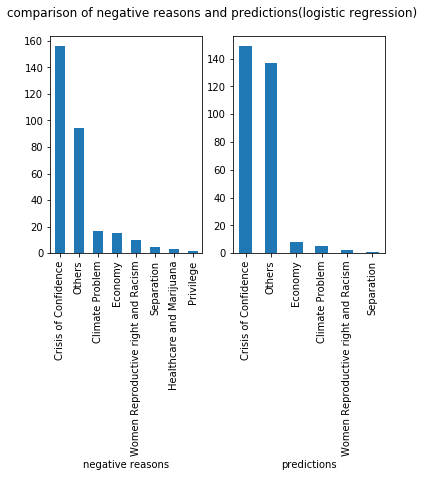

In [213]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('comparison of negative reasons and predictions(logistic regression)')
p1 = plt.subplot(121) 
resultsDF_lr['true'].value_counts().plot.bar() 
p1.set_xlabel('negative reasons')
plt.sca(p1)

p2 = plt.subplot(122)  
resultsDF_lr['predicted'].value_counts().plot.bar() 
p2.set_xlabel('predictions')
plt.sca(p2)
plt.show

In [174]:
#choose KNN
model2 = KNeighborsClassifier(n_neighbors=10)
model2.fit(X_train_ne,y_train_ne)
ne_pred = model2.predict(X_test_ne)

In [175]:
print('knn Accuracy: %.2f%%' % (accuracy_score(y_test_ne,ne_pred)*100))

knn Accuracy: 33.11%


In [180]:
#choose SVM
model3 = SVC()
model3.fit(X_train_ne,y_train_ne)
ne_pred = model3.predict(X_test_ne)

In [181]:
print('svm Accuracy: %.2f%%' % (accuracy_score(y_test_ne,ne_pred)*100))

svm Accuracy: 51.66%


# Step5.Results



## 5.1 First model

When implement the best model in election tweets, the accuracy_score is around 50%, which means the model can't give much reliable information about the election data. The reason is the word frequency of the two dataset is different and to reduce time conplexity, we only select 1000 features from data in Sentiment.csv, however, the election data contains 4305 features, so the model is underfitting.
The classification_report shows that the model we train in the Sentiment.csv can predict Positive sentiment much better than Negative Sentiment. The confusion metrix shows that the false negative is high. The reason is that the amount of Negative sentiments in Sentiment.csv is much more than the Positive sentiment, so the algorithm we choose seems more likely to predict Negative. To improve this, we can drop some of the Negative sentiment in training data to reduce the false negative.

Based on the amount of sentiments, most of them are Conservative and Liberal. However, there are much more Negative sentiments in Conservative both on the true labels and our predictions. Conservative is a topical party. But it had received a spate of unfavorable tweets. 
Liberal is also a topical party. And the percentagem of positive tweets is higher than other parties. So the public will more tend to give positive conments to liberal party.
The percentage of nagative tweets for NDP is much lower than Conservative, but the amount of tweets is much lower than Conservative and Liberal. Two political parties, Liberal Party and the Conservative Party, have dominated Canada politics.

## 5.2 Second model

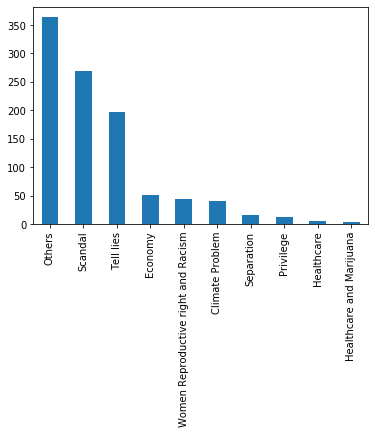

In [211]:
df_nega_el['negative_reason'].value_counts().plot.bar()

# Bonus

## Deep  Learning  algorithms

In [198]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-4,hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(X_train_wf, y_train)
nn_pred = clf.predict(X_test_wf)
acc_nn = accuracy_score(y_test,nn_pred)
f1_nn = f1_score(y_test,nn_pred)
print('30% testing data accuracy:',acc_nn)
print('30% testing f1_score:',f1_nn)

30% testing data accuracy: 0.7147011555827657
30% testing f1_score: 0.6939914632811645


In [196]:
#best classification model
resultDF_wf_2.iloc[0]

model                                           lr
hyperparams    {'C': 0.001, 'solver': 'newton-cg'}
train_acc                                 0.724592
train_std                               0.00131072
test_acc                                  0.715266
test_std                                0.00464788
accuracy                                  0.712864
f1_score                                  0.695751
Name: 0, dtype: object

Compared with the best classification model in testing data of Sentiment.csv, the accuracy improved.

In [200]:
#predict the sentiment of election data using NN
clf.fit(X_train_sen,y_train_sen)
y_el_pred=clf.predict(X_test_el)
print('Accuracy of nn: %.2f%%' % (accuracy_score(y_test_el, y_el_pred)*100))

Accuracy of nn: 59.49%


compared with the accuracy of the best classification model which is 51.66%, the accuracy imporved 8%.